In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import KNeighborsRegressor

In [2]:
df_oak = pd.read_csv('./datasets/oak.csv', sep=',')

df_oak.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Leukocytes       3000 non-null   float64
 1   Basophils (%)    3000 non-null   float64
 2   Eosinophils (%)  3000 non-null   float64
 3   Monocytes (%)    3000 non-null   float64
 4   Lymphocytes (%)  3000 non-null   float64
 5   Neutrophils (%)  3000 non-null   float64
 6   ESR (mm/h)       3000 non-null   float64
 7   Inflammation     3000 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 187.6 KB


In [3]:
df_oak.head()

,Leukocytes,Basophils (%),Eosinophils (%),Monocytes (%),Lymphocytes (%),Neutrophils (%),ESR (mm/h),Inflammation
0,5.72,0.28,2.65,7.78,27.79,57.90,19.270000,1
1,5.72,0.31,0.96,3.41,24.28,55.66,4.467824,1
2,9.00,0.51,5.33,4.03,26.00,59.76,7.840000,0
3,12.16,0.22,1.26,8.97,25.97,85.00,19.410000,1
4,5.00,0.23,2.17,7.81,24.41,64.50,6.770000,1


In [4]:
df_oak = df_oak.drop_duplicates()
df_oak.shape[0]

3000

предобработка:

In [5]:
def dcast(df):
    fcols = df.select_dtypes('float').columns
    icols = df.select_dtypes('int').columns

    df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
    df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')

    return df

### Предобработка и все остальное в файле check_dataset

In [6]:
columns_to_del = ["Basophils (%)"]

df_oak = df_oak.drop(columns=[col for col in columns_to_del if col in df_oak.columns])

df_oak.head()

,Leukocytes,Eosinophils (%),Monocytes (%),Lymphocytes (%),Neutrophils (%),ESR (mm/h),Inflammation
0,5.72,2.65,7.78,27.79,57.90,19.270000,1
1,5.72,0.96,3.41,24.28,55.66,4.467824,1
2,9.00,5.33,4.03,26.00,59.76,7.840000,0
3,12.16,1.26,8.97,25.97,85.00,19.410000,1
4,5.00,2.17,7.81,24.41,64.50,6.770000,1


## Кластеризация

### 1. PCA

![alt text](image.png)

обрежем df, убрав лейкоцитарную формулу (там где пропуски)

In [7]:
df_cut = df_oak.drop(columns='Inflammation', axis=1) # удаляем таргет
df_cut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Leukocytes       3000 non-null   float64
 1   Eosinophils (%)  3000 non-null   float64
 2   Monocytes (%)    3000 non-null   float64
 3   Lymphocytes (%)  3000 non-null   float64
 4   Neutrophils (%)  3000 non-null   float64
 5   ESR (mm/h)       3000 non-null   float64
dtypes: float64(6)
memory usage: 140.8 KB


снижаем размерность - то есть уменьшаем количество параметров, по которым будем делать кластеризацию. смотрим, какую долю данных описывает разное количество параметров

Text(0, 0.5, 'cumulative explained variance')

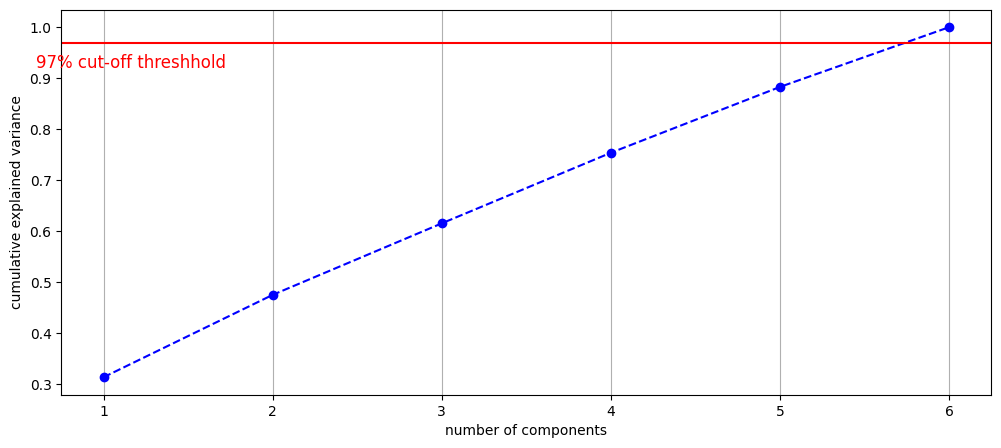

In [8]:
_df = df_cut.copy()

df_labels = pd.get_dummies(_df)

X_scaled = StandardScaler().fit_transform(df_labels)

pca = PCA(n_components=6).fit(X_scaled)
x_pca = pca.transform(X_scaled)

plt.figure(figsize=(12,5))
x = np.arange(1, len(pca.explained_variance_ratio_)+1,1)
plt.plot(x, np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--',color='b')
plt.axhline(y=0.97, color='r',linestyle='-')
plt.text(0.6, 0.92, '97% cut-off threshhold', color='red', fontsize='12')
plt.grid(axis='x')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [9]:
N_COMPONENTS = 6

снизить размерность не удается

Эльбоу-кривая: график зависимости суммы квадратов ошибок (SSE) от количества кластеров и выбрать точку, где наблюдается "излом" кривой.


Силуэтный коэффициент: показывает, насколько хорошо каждый объект вписывается в свой кластер. Коэффициент близкий к 1 указывает на хорошие кластеры.

In [10]:
distortions = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    distortions.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))


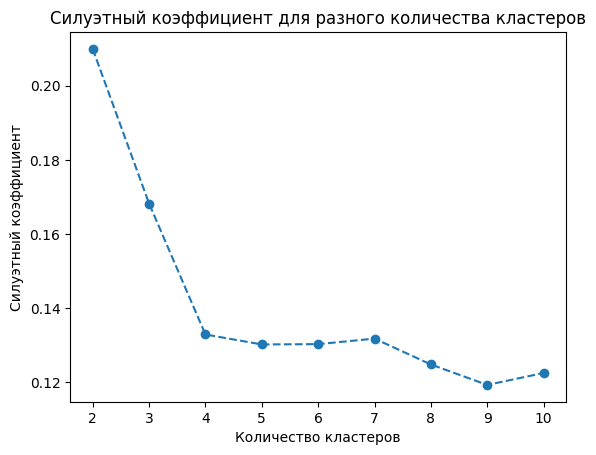

In [12]:
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Количество кластеров')
plt.ylabel('Силуэтный коэффициент')
plt.title('Силуэтный коэффициент для разного количества кластеров')
plt.show()

судя по второму графику, наилучшим выбором является 2 кластера: есть воспаление или нет

### K-means

In [13]:
df_clust = df_cut.copy()

kmeans = KMeans(n_clusters=2, random_state=42,init='k-means++')
df_clust['k-cluster'] = kmeans.fit_predict(X_scaled)

кластеризация происходит по комбинированным параметрам, которые ты получил после применения PCA (анализ главных компонент). PCA снижает размерность данных и создает новые компоненты, которые являются линейными комбинациями исходных признаков. эти новые компоненты представляют собой абстракцию, где каждый из них может быть смесью нескольких исходных параметров.

Чтобы учитывать, что 6 компонентов объясняют 90% вариативности данных, надо использовать больше компонентов, чем только первые 2, при создании визуализации. В PCA, при сохранении 90% вариативности, мы можем взять первые 6 компонентов и затем визуализировать их с использованием техники t-SNE или PCA с сохранением большего числа компонентов для лучшей визуализации.

t-SNE — это метод, который помогает эффективно визуализировать многомерные данные в 2D или 3D, сохраняет локальные структуры и группы, что особенно полезно при работе с большими наборами данных.

In [14]:
pca_6d = PCA(n_components=N_COMPONENTS).fit_transform(X_scaled)
tsne = TSNE(n_components=2, random_state=42)
pca_2d_tsne = tsne.fit_transform(pca_6d)

clusters = np.unique(df_clust['k-cluster'])

cmap = plt.get_cmap('viridis', len(clusters))

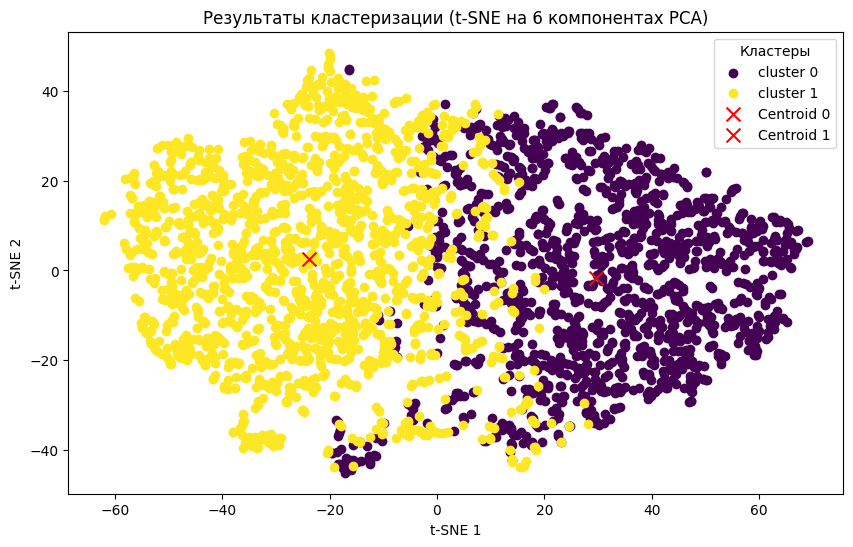

<Figure size 1000x600 with 0 Axes>

In [15]:
centroids = np.array([pca_2d_tsne[df_clust['k-cluster'] == cluster].mean(axis=0) for cluster in clusters])

cmap = plt.get_cmap('viridis', len(clusters))
plt.figure(figsize=(10, 6))

for cluster in clusters:
    indices = df_clust['k-cluster'] == cluster
    plt.scatter(pca_2d_tsne[indices, 0], pca_2d_tsne[indices, 1],
                color=cmap(cluster), label=f'cluster {cluster}')

for i, centroid in enumerate(centroids):
    plt.scatter(centroid[0], centroid[1], color='red', marker='x', s=100, label=f'Centroid {clusters[i]}')

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Результаты кластеризации (t-SNE на 6 компонентах PCA)')
plt.legend(title='Кластеры')
plt.figure(figsize=(10, 6))
plt.show()

Координаты центроид:

In [16]:
centroids

array([[ 29.58043  ,  -1.735327 ],
       [-23.808722 ,   2.4964716]], dtype=float32)

In [17]:
kmeans.cluster_centers_

array([[ 0.44620781, -0.20671798,  0.61317915, -0.48338976,  0.48970485,
         0.64053579],
       [-0.39569372,  0.18331595, -0.54376264,  0.42866639, -0.43426656,
        -0.56802231]])

- Ось X — это первый компонент, полученный после применения t-SNE. Он отображает одно из новых измерений, созданных после применения t-SNE для проекции данных в 2D.
- Ось Y — это второй компонент, аналогично отображающий другое новое измерение, полученное t-SNE.

t-SNE работает так, чтобы сохранить локальную структуру данных и группировки, которые существовали в более высокоразмерных данных, в 2D-пространстве. То есть:

Каждая точка на графике — это результат преобразования одного объекта из исходных данных в новое 2D-пространство, где сохраняется информация о сходстве объектов.
Точки, которые оказались рядом друг с другом на графике, в исходном пространстве были также схожи (в соответствии с метрикой t-SNE), и наоборот.

средние значения параметров для различных кластеров:

In [18]:
df_clust.groupby('k-cluster').mean()

,Leukocytes,Eosinophils (%),Monocytes (%),Lymphocytes (%),Neutrophils (%),ESR (mm/h)
k-cluster,,,,,,
0,9.260522,2.512226,7.203067,24.582753,65.557518,20.459155
1,6.876590,3.093966,5.059887,30.307904,54.781302,10.137317


медианные (наиболее часто встречающиеся) значения параметров для различных кластеров:

In [19]:
df_clust.groupby('k-cluster').median()

,Leukocytes,Eosinophils (%),Monocytes (%),Lymphocytes (%),Neutrophils (%),ESR (mm/h)
k-cluster,,,,,,
0,8.92,2.41,7.08,24.53,65.135,19.745
1,6.81,2.90,4.97,30.18,54.175,9.520


теперь сравним кластеры с изначальной разметкой:

In [20]:
# проверяем совпадают ли индексы датафреймов, чтобы можно было соединить их по индексам
print((df_oak.index == df_clust.index).all()) 

True


In [21]:
df_result = df_oak.copy()
df_result['k-cluster'] = df_clust['k-cluster']
df_result.head()

,Leukocytes,Eosinophils (%),Monocytes (%),Lymphocytes (%),Neutrophils (%),ESR (mm/h),Inflammation,k-cluster
0,5.72,2.65,7.78,27.79,57.90,19.270000,1,0
1,5.72,0.96,3.41,24.28,55.66,4.467824,1,1
2,9.00,5.33,4.03,26.00,59.76,7.840000,0,1
3,12.16,1.26,8.97,25.97,85.00,19.410000,1,0
4,5.00,2.17,7.81,24.41,64.50,6.770000,1,1


In [22]:
matches = (df_result['Inflammation'] == df_result['k-cluster'])
mtch = matches.sum()

print('совпадений:', mtch)
print('доля совпадений:', mtch / df_result.shape[0])

совпадений: 363
доля совпадений: 0.121


In [23]:
cross_tab = pd.crosstab(df_result['Inflammation'], df_result['k-cluster'])

total = cross_tab.values.sum()

print("\nотносительные значения (%):")
(cross_tab / total * 100).round(2)


относительные значения (%):


k-cluster,0,1
Inflammation,,
0,4.10,45.27
1,42.63,8.00


вообще, k-cluster это просто 0 и 1, непонятно, что из этого воспаление, а что нет. поэтому можно ревертнуть значения k-cluster, соединить датафрейм и посмотреть на совпадения

In [23]:
df_result_rev = df_oak.copy()
df_result_rev['k-cluster'] = 1 - df_clust['k-cluster']
df_result_rev.head()

,Leukocytes,Eosinophils (%),Monocytes (%),Lymphocytes (%),Neutrophils (%),ESR (mm/h),Inflammation,k-cluster
0,5.72,2.65,7.78,27.79,57.90,19.270000,1,1
1,5.72,0.96,3.41,24.28,55.66,4.467824,1,0
2,9.00,5.33,4.03,26.00,59.76,7.840000,0,0
3,12.16,1.26,8.97,25.97,85.00,19.410000,1,1
4,5.00,2.17,7.81,24.41,64.50,6.770000,1,0


In [24]:
matches_rev = (df_result_rev['Inflammation'] == df_result_rev['k-cluster'])
mtch_rev = matches_rev.sum()

print('совпадений:', mtch_rev)
print('доля совпадений:', mtch_rev / df_result_rev.shape[0])

совпадений: 2637
доля совпадений: 0.879


In [25]:
cross_tab = pd.crosstab(df_result_rev['Inflammation'], df_result_rev['k-cluster'])

total = cross_tab.values.sum()

print("\nотносительные значения (%):")
(cross_tab / total * 100).round(2)


относительные значения (%):


k-cluster,0,1
Inflammation,,
0,45.27,4.10
1,8.00,42.63


то есть если судить по **неинвертированному** разбиению на кластеры (относительно того какие значение присваиваются кластерам) то получается так:

1 - нет воспаления

0 - есть воспаление

будем использовать **df_result_rev** без столбца *Inflammation* для проверки пользовательских значений - вычислять расстояние от введенных данных до центроид. кластер с наименьшим расстоянием от точки введенных данных будем считать за более вероятный вердикт

In [26]:
df_fin = df_result_rev.drop(columns=['Inflammation'])

df_fin.head()

,Leukocytes,Eosinophils (%),Monocytes (%),Lymphocytes (%),Neutrophils (%),ESR (mm/h),k-cluster
0,5.72,2.65,7.78,27.79,57.90,19.270000,1
1,5.72,0.96,3.41,24.28,55.66,4.467824,0
2,9.00,5.33,4.03,26.00,59.76,7.840000,0
3,12.16,1.26,8.97,25.97,85.00,19.410000,1
4,5.00,2.17,7.81,24.41,64.50,6.770000,0


In [43]:
scaler = StandardScaler().fit(df_labels)
X_scaled = scaler.transform(df_labels)

pca = PCA(n_components=6).fit(X_scaled)
X_pca = pca.transform(X_scaled)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

knn_tsne = KNeighborsRegressor(n_neighbors=5)
knn_tsne.fit(X_pca, X_tsne)

joblib.dump(knn_tsne, 'knn_tsne.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca, 'pca.pkl')
np.save('centroids_2d.npy', centroids)

### DBSCAN

In [ ]:
df_db = df_cut.copy()  # копируем исходные данные

eps_values = [0.5, 1, 1.5, 2, 2.5, 3, 3.5]  # попробуй разные значения
best_results = []

for eps in np.arange(0.5, 10, 0.5):
    silhouette_scores = []
    
    for min_samples in range(2, 101, 1):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)

        if len(set(labels) - {-1}) > 1:
            score = silhouette_score(X_scaled, labels)
        else:
            score = -1  # один кластер — нет смысла в силуэте

        silhouette_scores.append(score)

    # сохраняем лучший результат для данного eps
    best_min_samples = range(2, 101, 1)[np.argmax(silhouette_scores)]
    best_silhouette = max(silhouette_scores)
    best_results.append((eps, best_min_samples, best_silhouette))

KeyboardInterrupt: 

: 

: 

: 

: 

In [ ]:
# выводим лучшие параметры для каждого eps
df_best = pd.DataFrame(best_results, columns=['eps', 'Лучший min_samples', 'Лучший Silhouette Score'])

df_best = df_best.sort_values('Лучший Silhouette Score', ascending=False)

df_best

,eps,Лучший min_samples,Лучший Silhouette Score
3,2.0,2,0.368012
2,1.5,4,0.343189
1,1.0,15,-0.000568
0,0.5,6,-0.185963
4,2.5,2,-1.000000
5,3.0,2,-1.000000
6,3.5,2,-1.000000
7,4.0,2,-1.000000
8,4.5,2,-1.000000
9,5.0,2,-1.000000


: 

: 

: 

: 

[ 0 -1  1]


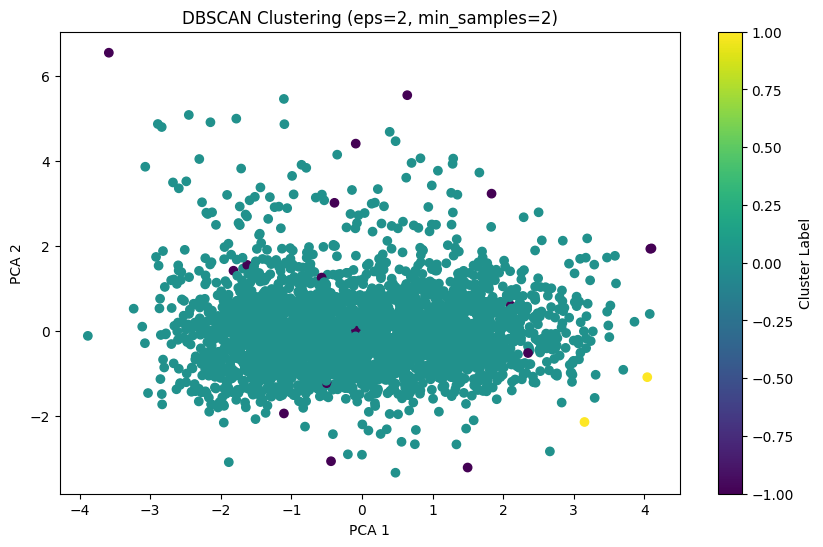

: 

: 

: 

: 

In [ ]:
# подставляем найденные лучшие параметры
best_eps = 2 # замените на найденное значение
best_min_samples = 2  # замените на найденное значение

# применяем DBSCAN с лучшими параметрами
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
df_db['dbscan_cluster'] = dbscan.fit_predict(X_scaled)

print(df_db['dbscan_cluster'].unique())

# повторно строим график
pca_2d = PCA(n_components=N_COMPONENTS).fit_transform(X_scaled)
plt.figure(figsize=(10, 6))
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=df_db['dbscan_cluster'], cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title(f'DBSCAN Clustering (eps={best_eps}, min_samples={best_min_samples})')
plt.colorbar(label="Cluster Label")  # Добавляем легенду для кластеров
plt.show()

это просто ужас

по силуэтному коэффициенту было понятно, что ничего хорошего не выйдет

### Иерархическая (agglomerative) кластеризация

Text(0.5, 1.0, 'Agglomerative Clustering Results with t-SNE')

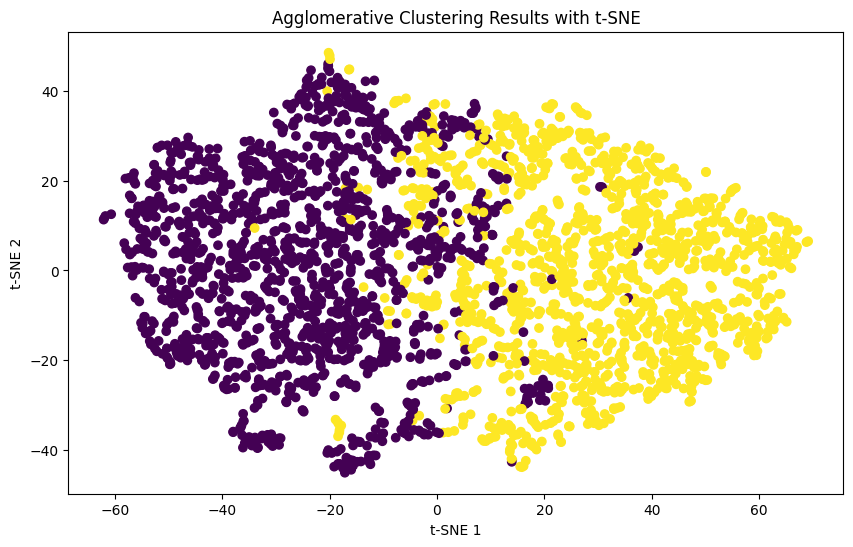

: 

: 

: 

: 

In [ ]:
df_agg = df_cut.copy()

agg_clustering = AgglomerativeClustering(n_clusters=2)
df_agg['agg_cluster'] = agg_clustering.fit_predict(X_scaled)

pca_2d = PCA(n_components=N_COMPONENTS).fit_transform(X_scaled)
tsne_2d = TSNE(n_components=2, random_state=42).fit_transform(pca_2d)

plt.figure(figsize=(10, 6))
plt.scatter(tsne_2d[:, 0], tsne_2d[:, 1], c=df_agg['agg_cluster'], cmap='viridis')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Agglomerative Clustering Results with t-SNE')


In [ ]:
df_agg.groupby('agg_cluster').mean()

,Leukocytes,Eosinophils (%),Monocytes (%),Lymphocytes (%),Neutrophils (%),ESR (mm/h)
agg_cluster,,,,,,
0,7.037299,3.158045,5.145565,30.221047,54.836402,10.259312
1,9.045829,2.450294,7.075133,24.767331,65.330049,20.164671


: 

: 

: 

: 

In [ ]:
df_agg.groupby('agg_cluster').median()

,Leukocytes,Eosinophils (%),Monocytes (%),Lymphocytes (%),Neutrophils (%),ESR (mm/h)
agg_cluster,,,,,,
0,6.95,2.90,5.040,30.160,54.220,9.585
1,8.76,2.44,6.985,24.665,65.035,19.640


: 

: 

: 

: 

## Итог - K-means победил

# Выявление аномалий


In [ ]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_cut)

pca = PCA(n_components=N_COMPONENTS)
data_pca = pca.fit_transform(data_scaled)

data_reconstructed = pca.inverse_transform(data_pca)
reconstruction_error = np.mean((data_scaled - data_reconstructed) ** 2, axis=1)

threshold = np.percentile(reconstruction_error, 97)

: 

: 

: 

: 

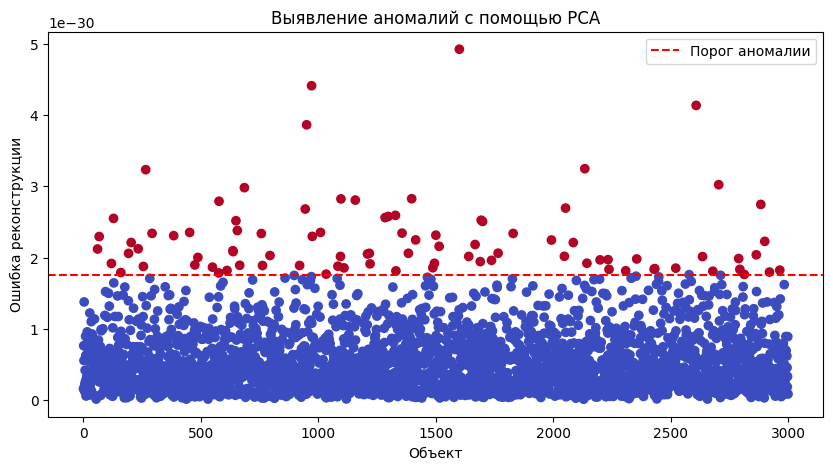

: 

: 

: 

: 

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(range(len(reconstruction_error)), reconstruction_error, c=(reconstruction_error > threshold), cmap="coolwarm")
plt.axhline(threshold, color='r', linestyle='dashed', label="Порог аномалии")
plt.xlabel("Объект")
plt.ylabel("Ошибка реконструкции")
plt.title("Выявление аномалий с помощью PCA")
plt.legend()
plt.show()

In [ ]:
anomalies = np.where(reconstruction_error > threshold)[0]
df_anom = df_cut.loc[anomalies]
df_anom

,Leukocytes,Eosinophils (%),Monocytes (%),Lymphocytes (%),Neutrophils (%),ESR (mm/h)
60,9.040000,1.74,12.00,26.06,56.44,20.030000
67,4.850000,1.58,3.10,22.76,70.84,-2.100433
119,7.080000,3.44,9.83,27.87,79.09,39.507527
128,19.210347,4.62,7.75,13.90,58.09,25.090000
159,7.080000,2.12,10.40,29.13,57.09,31.750000
...,...,...,...,...,...,...
2864,3.420000,1.61,3.99,39.27,35.00,8.570000
2883,12.340000,2.76,12.00,21.77,51.28,25.970000
2900,7.160000,4.13,9.59,16.52,80.45,31.110000
2920,12.830000,1.51,9.74,29.59,63.64,33.860000


: 

: 

: 

: 